![HydroSAR Banner](./NotebookAddOns/HydroSARbanner.jpg)

# Flood Mapping from Single Sentinel-1 SAR Images

**Franz J Meyer, University of Alaska Fairbanks**

This notebook presents the SAR-based flood mapping approach developed and used in the HydroSAR project. In its general concepts, the approach follows a methodology developed by the German Aerospace Center and published in [Sentinel-1-based flood mapping: a fully automated processing chain](https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1192304) by Twele et al. The approach is based on radiometrically terrain corrected (RTC processed) Sentinel-1 SAR data and applies a dynamic thresholding method followed by fuzzy-logic-based post processing procedure. This notebook has both steps of this process implemented, but by default, the fuzzy logic step is deactivated to save processing time. The notebook will explain how the fuzzy logic post processing step can be activated should full performance processing be of interest. 

The approach is based on image amplitude data and is capable of detecting standing surface water. Note that flooding under vegetation will not be detected by this approach.

# HYDRO30 Surface water extent map product

This notebook mimics the workflow the HyP3 HydroSAR plugin will follow to create an On Demand surface water extent map product. It is intended demonstrate *how* HyP3 goes from an On Demand request to a product, as well as provide a platform for testing/tuning/refinement ot the water extent map product.

Importantly, step 2 will become the plugin's primary interface, and the options provided to the `make_water_map` function can be exposed to users. Step 1 is a required data marshaling step that will be handled transparently inside the container.

If you'd like an overview of the water extent mapping process, run the following cell to get the `make_water_map` documentation, otherwise, skip to step 1.

***
Note: Loading make_water_map function can take up to two minutes. 

In [1]:
from hydrosar.water_map import make_water_map

make_water_map?

Signature:
make_water_map(
    out_raster: Union[str, pathlib.Path],
    vv_raster: Union[str, pathlib.Path],
    vh_raster: Union[str, pathlib.Path],
    hand_raster: Union[str, pathlib.Path, NoneType] = None,
    tile_shape: Tuple[int, int] = (100, 100),
    max_vv_threshold: float = -15.5,
    max_vh_threshold: float = -23.0,
    hand_threshold: float = 15.0,
    hand_fraction: float = 0.8,
    membership_threshold: float = 0.45,
)
Docstring:
Creates a surface water extent map from a Sentinel-1 RTC product

Create a surface water extent map from a dual-pol Sentinel-1 RTC product and
a HAND image. The HAND image must be pixel-aligned (same extent and size) to
the RTC images. The water extent maps are created using an adaptive Expectation
Maximization thresholding approach and refined with Fuzzy Logic.

The input images are broken into a set of corresponding tiles with a shape of
`tile_shape`, and a set of tiles are selected from the VH RTC
image that contain water boundaries to deter

# General Methodology and Workflow

Note: This workflow is done within the make_water_map function. It is described here only for illustrative purposes. 

The workflow of the Sentinel-1-based processing chain, as outlined in the figure below, is composed of the following main elements: 

1. **Find relevant SAR data** over your area of interest at the [Alaska Satellite Facility's SAR archive](https://search.asf.alaska.edu/#/)
1. **Perform geometric and radiometric terrain correction** using the RTC processing flow by [GAMMA Remote Sensing](https://www.gamma-rs.ch/)
1. **initial flood detection** using automatic thresholding
1. **fuzzy-logic-based classification refinement**
1. **>final classification into permanent and flood waters** using auxiliary data
1. **dissemination of the results**

***Steps 1 and 2*** of this workflow are operationally implemented in the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline (HyP3) environment and accessible to the public at the [ASF Search (Vertex)](https://search.asf.alaska.edu/#/).

<img style= "padding: 7px" src="https://courses.edx.org/asset-v1:AlaskaX+SAR-401+3T2020+type@asset+block@Watermappingworkflow2.jpg" width="70%"/>

# Flood Mapping Procedure

## Loading Python Libraries

In [3]:
# import remaining libraries
from pathlib import Path
import os
import glob
from pathlib import Path
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
!pip install ipyfilechooser

In [5]:
from ipyfilechooser import FileChooser

## 2. Generate the water extent map

Now that we have marshalled all the required input data, we can generate the surface water extent map!

**Note:** this will take $\approx$ 30 minutes to complete.

***
Get the list of VV and VH rasters and their paths. 

Sort them by date. 

In [6]:
fc_subset = FileChooser(Path.cwd())
display(fc_subset)

FileChooser(path='/home/jovyan/hydrosar', filename='', title='', show_hidden=False, select_desc='Select', chan…

In [14]:
# get list of rasters
vv_rasters = glob.glob(fc_subset.selected + 'RTC_GAMMA/*_VV_subset.tif*')
vh_rasters = glob.glob(fc_subset.selected + 'RTC_GAMMA/*_VH_subset.tif*')
# sort raster paths by date
vv_rasters.sort()
vh_rasters.sort()

# print raster paths
for vv, vh in zip(vv_rasters,vh_rasters): 
    print(f"vv = {vv}")
    print(f"vh = {vh}")

vv = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190108T120439_DVP_RTC30_G_gpufem_8BD9_VV_subset.tif
vh = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190108T120439_DVP_RTC30_G_gpufem_8BD9_VH_subset.tif
vv = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190120T120439_DVP_RTC30_G_gpufem_97E2_VV_subset.tif
vh = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190120T120439_DVP_RTC30_G_gpufem_97E2_VH_subset.tif
vv = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190201T120439_DVP_RTC30_G_gpufem_5EF2_VV_subset.tif
vh = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190201T120439_DVP_RTC30_G_gpufem_5EF2_VH_subset.tif
vv = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190213T120438_DVP_RTC30_G_gpufem_CA11_VV_subset.tif
vh = /home/jovyan/hydrosar/Dataset/bang_NE/subset_East/RTC_GAMMA/S1A_IW_20190213T120438_DVP_RTC30_G_gpufem_CA11_VH_sub

***
Create the water mask folder and water mask path names. 

In [15]:
# create list of names for water extent rasters

water_extent_rasters = []

folder_waterMasks = 'Water_Masks'

# I assume that the vv_rasters and vh_rasters contain the same set, so I just have to loop through one of them to construct all of my file names. 
for vv in vv_rasters:
    # parse raster name. 
    pathNflnm, file_extension = os.path.splitext(vv)
    pieces_path = pathNflnm.split('/') # the pieces of the path. 
    pieces_flnm = pieces_path[-1].split('VV') # the pieces of the file name (flnm) (last one in the list). 

    # create water raster path and file name. 
    water_flnm = pieces_flnm[0][:-1] + pieces_flnm[1] + '_water_mask_combined' + file_extension
    # put water raster path and file name together. 
    water_extent_raster = os.path.join('/',*pieces_path[:-2],folder_waterMasks,water_flnm)
    # print(water_extent_raster)
    # add the water_extent_raster name to my list of them
    water_extent_rasters.append(water_extent_raster)
water_extent_rasters.sort()

# create water mask folder
path_waterMasks = Path(os.path.join('/',*pieces_path[:-2],folder_waterMasks))
# print(path_waterMasks)
if not path_waterMasks.exists():
    path_waterMasks.mkdir()
    print(f"Folder {folder_waterMasks} created.")
else:
    print(f"Folder {folder_waterMasks} exists.")

# for water_extent in water_extent_rasters:
#     print(water_extent)

Folder Water_Masks created.


***
Loop through and create the water mask for each VV and VH pair. 

In [ ]:
for (water_extent_raster, vv_raster, vh_raster) in zip(water_extent_rasters, vv_rasters, vh_rasters):
    # print(f" water = {water_extent_raster}\n vv =    {vv_raster}\n vh =    {vh_raster}")

    # check that the start of the last part vh/vv_raster (before the 'VV'/'VH') is contained in the water raster. 
    pathNflnm, file_extension = os.path.splitext(vv_raster)
    # print(pathNflnm)
    pieces = pathNflnm.split(os.path.sep)
    # print(pieces)
    piece_vv = pieces[-1].split('VV')

    pathNflnm, file_extension = os.path.splitext(vh_raster)
    pieces = pathNflnm.split(os.path.sep)
    piece_vh = pieces[-1].split('VH')
    
    # print(piece_vv[1])
    if (piece_vv[0]==piece_vh[0]) and (piece_vv[0] in water_extent_raster):
        print('awesome!')
        make_water_map(water_extent_raster, vv_raster, vh_raster, tile_shape=(100, 100),
               max_vv_threshold=-15.5, max_vh_threshold=-23., hand_threshold=15., hand_fraction=0.8)
    else:
        print(f'The names of the rasters do not match.\n Water Mask = {water_extent_raster}\n VV Raster = {piece_vv[0]}\n VH Raster = {piece_vh[0]}')
    

awesome!
awesome!
awesome!
awesome!
awesome!
awesome!
awesome!
awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!
awesome!
awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!
awesome!


Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db
Threshold too high! Using maximum threshold -15.5 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!
awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!
awesome!
awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


awesome!


Threshold too high! Using maximum threshold -23.0 db


## 3. Create figures used in FIER loop



***
Choose the data folder.

NOTE: This is the subset folder. 

In [ ]:
# fc = FileChooser(Path.cwd())
# display(fc)

fc = fc_subset
fc.selected

In [35]:
def get_tiff_paths(paths: str) -> list:
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

In [36]:
tiff_dir = Path(fc.selected,'Water_Masks')
paths = tiff_dir/'*_water_mask_combined.tif*'

if tiff_dir.exists():
    tiff_paths = get_tiff_paths(paths)
tiff_paths.sort()
tiff_paths

['/home/jovyan/hydrosar/Dataset/bang_NE/subset_West/Water_Masks/S1A_IW_20190108T120439_DVP_RTC30_G_gpufem_8BD9_subset_water_mask_combined.tif',
 '/home/jovyan/hydrosar/Dataset/bang_NE/subset_West/Water_Masks/S1A_IW_20190120T120439_DVP_RTC30_G_gpufem_97E2_subset_water_mask_combined.tif',
 '/home/jovyan/hydrosar/Dataset/bang_NE/subset_West/Water_Masks/S1A_IW_20190201T120439_DVP_RTC30_G_gpufem_5EF2_subset_water_mask_combined.tif',
 '/home/jovyan/hydrosar/Dataset/bang_NE/subset_West/Water_Masks/S1A_IW_20190213T120438_DVP_RTC30_G_gpufem_CA11_subset_water_mask_combined.tif',
 '/home/jovyan/hydrosar/Dataset/bang_NE/subset_West/Water_Masks/S1A_IW_20190225T120438_DVP_RTC30_G_gpufem_C14B_subset_water_mask_combined.tif',
 '/home/jovyan/hydrosar/Dataset/bang_NE/subset_West/Water_Masks/S1A_IW_20190309T120438_DVP_RTC30_G_gpufem_4755_subset_water_mask_combined.tif',
 '/home/jovyan/hydrosar/Dataset/bang_NE/subset_West/Water_Masks/S1A_IW_20190321T120438_DVP_RTC30_G_gpufem_73AE_subset_water_mask_combine

***
Calculate the flood percentages for each SAR acquisition using the water masks produced in previous steps of this notebook.

In [37]:
floodpercent = np.array([])
total = len(tiff_paths)
county = 0
print("starting")
for tiff in tiff_paths:
    f = gdal.Open(tiff)
    unique_elements, counts = np.unique(f.ReadAsArray(), return_counts=True)
    myDict = dict(zip(unique_elements,counts))
    myArea = myDict[0] + myDict[1]
    flooded = myDict[1]
    floodpercent = np.append(floodpercent,flooded/myArea*100.0)
    county += 1
    print(f"{county} of {total} complete")

starting
1 of 154 complete
2 of 154 complete
3 of 154 complete
4 of 154 complete
5 of 154 complete
6 of 154 complete
7 of 154 complete
8 of 154 complete
9 of 154 complete
10 of 154 complete
11 of 154 complete
12 of 154 complete
13 of 154 complete
14 of 154 complete
15 of 154 complete
16 of 154 complete
17 of 154 complete
18 of 154 complete
19 of 154 complete
20 of 154 complete
21 of 154 complete
22 of 154 complete
23 of 154 complete
24 of 154 complete
25 of 154 complete
26 of 154 complete
27 of 154 complete
28 of 154 complete
29 of 154 complete
30 of 154 complete
31 of 154 complete
32 of 154 complete
33 of 154 complete
34 of 154 complete
35 of 154 complete
36 of 154 complete
37 of 154 complete
38 of 154 complete
39 of 154 complete
40 of 154 complete
41 of 154 complete
42 of 154 complete
43 of 154 complete
44 of 154 complete
45 of 154 complete
46 of 154 complete
47 of 154 complete
48 of 154 complete
49 of 154 complete
50 of 154 complete
51 of 154 complete
52 of 154 complete
53 of 154 co

In [38]:
def get_dates(paths):
    dates = []
    for pth in paths: 
        name = str(pth).split('/')[-1]
        dateNtime = str(name).split('_')[2]
        date = str(dateNtime).split('T')[0]
        dates.append(date)
    dates.sort()
    return dates

***
Create and save flood percentages as a function of date, and a figure of the same. 

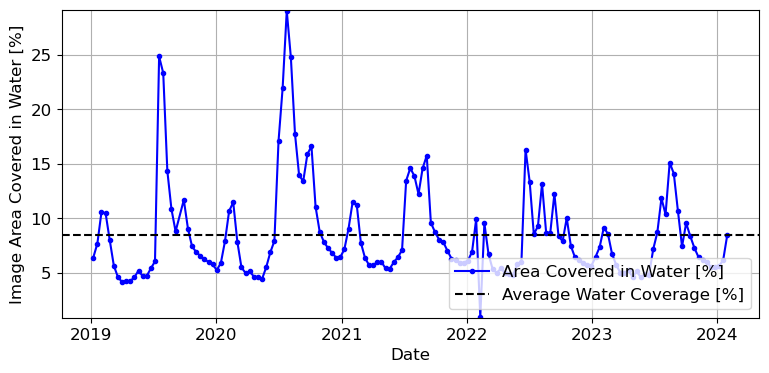

In [41]:
pathfig = Path(fc.selected,'Figures')
pathfig.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({'font.size': 12})
dates = get_dates(tiff_paths)
time_index = pd.DatetimeIndex(dates)

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)  # 121 determines: 2 rows, 2 plots, first plot
ax1.plot(np.unique(time_index), floodpercent, color='b', marker='o', markersize=3, label='Area Covered in Water [%]')
ax1.set_ylim([np.min(floodpercent)-np.min(floodpercent)*0.1, np.max(floodpercent)+np.min(floodpercent)*0.1])
ax1.set_xlabel('Date')
ax1.axhline(y=np.mean(floodpercent), color='k', linestyle='--', label='Average Water Coverage [%]')
ax1.set_ylabel('Image Area Covered in Water [%]')
ax1.grid()
figname = ('ThresholdAndAreaTS.png')
ax1.legend(loc='lower right')
plt.savefig(pathfig/figname, dpi=300, transparent='true')
np.save(pathfig/'time_index.npy', time_index)
np.save(pathfig/"flood_percentage.npy", floodpercent)

`make_water_map` in [water_map.py](../src/hydrosar/water_map.py) is the primary "science" interface for generating the water maps. It *should* include all the necessary options for tuning the product -- if it doesn't, and you'd like other things exposed, either:
* Ask us to expose it by [Opening an issue](https://github.com/HydroSAR/HydroSAR/issues/new/choose)
* [Fork](https://github.com/HydroSAR/HydroSAR/fork) and propose changes in a Pull Request.

For more info on the `make_water_map` function, run the cell below.

In [ ]:
from hydrosar.water_map import make_water_map
make_water_map?